In [1]:
import numpy as np
import pandas as pd
import os, joblib

from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

from tqdm import tqdm

import seaborn as sns

In [85]:
all_df = pd.read_csv('Results/All_speeches_labelled.csv')

with open('Results/Official_TopicModel_80k.pkl','rb') as File:
    models = joblib.load(File)
    
mapper = models['mapper']
mapper = mapper.loc[-mapper.dynamic_label.isin(['procedural','tribute','NA'])]

In [3]:
def make_adj(mat):
    mat_cols = mat.shape[1]
    adj = np.zeros([mat_cols,mat_cols])
    for i in range(mat_cols):
        for ii in range(mat_cols):
            if i != ii:
                adj[i,ii] = 1 - cosine(mat[:,i],mat[:,ii])
            else:
                adj[i,ii] = 1
    return adj
    

In [193]:
def run_count(year,percentile=90):
    sub_df = all_df.loc[(all_df.year_y == year) & (-all_df.dynamic_label.isin(['procedural','NA','tribute']))]
    sub_df = sub_df.loc[-sub_df.dynamic_label.isnull()]
    sub_parties = sub_df[['speaker','party_y']].groupby('speaker').first()

    speaker_counts = (sub_df
                      .groupby(['speaker','dynamic_label'])
                      .party_x.count()
                      .reset_index()
                      .pivot(index='speaker',columns='dynamic_label',values='party_x')
                      .fillna(0)
                      .reset_index()
                      .merge(sub_parties,on='speaker',how='left')
                     )

    Dem_matrix = speaker_counts.loc[speaker_counts.party_y == 'D'].drop(['speaker','party_y'],1).to_numpy()
    Rep_matrix = speaker_counts.loc[speaker_counts.party_y == 'R'].drop(['speaker','party_y'],1).to_numpy()

    dem_adj = make_adj(Dem_matrix)
    rep_adj = make_adj(Rep_matrix)
    
    upper_D = dem_adj[np.triu_indices_from(dem_adj,1)]
    upper_R = rep_adj[np.triu_indices_from(rep_adj,1)]
    
    top_10_d = np.percentile(upper_D,percentile)
    top_10_r = np.percentile(upper_R,percentile)
    
    dem_adj[np.where(dem_adj < top_10_d)] = 0
    dem_adj[np.where(dem_adj != 0 )] = 1
    
    rep_adj[np.where(rep_adj < top_10_r)] = 0
    rep_adj[np.where(rep_adj != 0 )] = 1
    
    upper_D = dem_adj[np.triu_indices_from(dem_adj,1)]
    upper_R = rep_adj[np.triu_indices_from(rep_adj,1)]
    
    return {"year":year,'similarity':1 - cosine(upper_D,upper_R)}

<AxesSubplot:xlabel='year'>

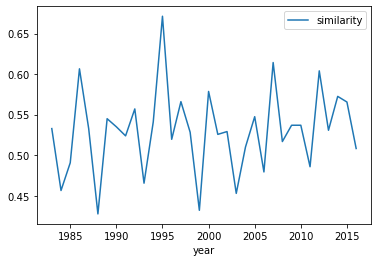

In [199]:
Frame = []
for year in range(1983,2017):
    Frame.append(run_count(year,percentile=70))
pd.DataFrame(Frame).plot(x='year',y='similarity')

In [195]:
def run_dists(year,percentile=90):
    sub_df = all_df.loc[(all_df.year_y == year)].reset_index()
    sub_df = sub_df.loc[-sub_df.dynamic_label.isin(['procedural','NA','tribute'])]
    sub_df = sub_df.loc[-sub_df.dynamic_label.isnull()]

    sub_parties = sub_df[['speaker','party_y']].groupby('speaker').first().reset_index()

    W = [mod['W'] for mod in models['window_models'] if mod['year'] == year][0]    

    topic_ix = mapper.loc[mapper.year == str(year),'topic_id'].values

    W = W[sub_df.index.to_numpy(),:]
    W = W[:,topic_ix]

    df = pd.DataFrame(W)
    df['speaker'] = list(sub_df.speaker)

    df = (df
        .groupby('speaker')
        .mean()
        .reset_index()
        .merge(sub_parties,on='speaker',how='left')
         )

    Dem_matrix = df.loc[df.party_y == 'D'].drop(['speaker','party_y'],1).to_numpy()
    Rep_matrix = df.loc[df.party_y == 'R'].drop(['speaker','party_y'],1).to_numpy()

    dem_adj = make_adj(Dem_matrix)
    rep_adj = make_adj(Rep_matrix)

    upper_D = dem_adj[np.triu_indices_from(dem_adj,1)]
    upper_R = rep_adj[np.triu_indices_from(rep_adj,1)]

    top_10_d = np.percentile(upper_D,percentile)
    top_10_r = np.percentile(upper_R,percentile)

    dem_adj[np.where(dem_adj < top_10_d)] = 0
    dem_adj[np.where(dem_adj != 0 )] = 1

    rep_adj[np.where(rep_adj < top_10_r)] = 0
    rep_adj[np.where(rep_adj != 0 )] = 1

    upper_D = dem_adj[np.triu_indices_from(dem_adj,1)]
    upper_R = rep_adj[np.triu_indices_from(rep_adj,1)]

    return {"year":year,'similarity':1 - cosine(upper_D,upper_R)}


<AxesSubplot:xlabel='year'>

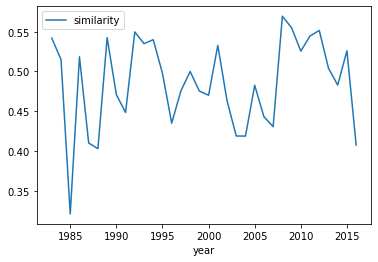

In [200]:
Frame = []
for year in range(1983,2017):
    Frame.append(run_dists(year,percentile=70))
pd.DataFrame(Frame).plot(x='year',y='similarity')